# Lesson 9: Communicating Results
## Starter code for guided practice & demos

## Activity: "Which metric should I use?"
While AUC seems like a “golden standard”, it could be further improved depending upon your problem.  There will be instances where error in positive or negative matches will be very important.  For each of the following examples:

1. Write a confusion matrix: true positive, false positive, true negative, false negative. Then decide what each square represents for that specific example.
2. Define the benefit of a true positive and true negative.
3. Define the cost of a false positive and false negative.
4. Determine at what point does the cost of a failure outweigh the benefit of a success? This would help you decide how to optimise TPR, FPR, and AUC.

**Examples:**
- A test is developed for determining if a patient has cancer or not.
- A website is targeting a marketing retention campaign for paying customers “at risk" of churning.
- You build a spam classifier for your email system.

- A test is developed for determining if a patient has cancer or not.

| |True|False|
|--|--|--|
|True| Test positive; patient has cancer| Test positive; patient doesn't have cancer|
|False|Test negative; patient has cancer| Test negative; patient doesn't have cancer|

False negative is most costly because potentially results in death if cancer not detected. Costs to a false positive potentially costly in economic sense in terms of wasted costs for treatment, and also potential side effects for patient.

- A website is targeting a marketing retention campaign for paying customers “at risk" of churning.


| |True|False|
|--|--|--|
|True| Customer sent email; customer at risk| Customer sent email; customer not at risk|
|False|Customer not sent email; customer at risk| Customer not sent email; customer not at risk|

False negative is most costly because you could potentially lose a customer, and the cost of sending email to try to retain them is probably very low. False positive potentially has smaller economic cost if you are offering discounts to retain a customer who isn't at risk of churning.

- You build a spam classifier for your email system.

| |True|False|
|--|--|--|
|True| Flagged as spam; is spam| Flagged as spam; isn't spam|
|False|Not flagged as spam; is spam| Not flagged as spam; isn't spam|

False negative is annoying as results in spam filling your inbox; false positive potentially more costly if important mail is not seen.

## Activity: "Cost Benefit Analysis"
One tool that complements the confusion matrix is cost-benefit analysis, where you attach a value to correctly and incorrectly predicted data.

Like the Precision-Recall trade off, there is a balancing point to the probabilities of a given position in the confusion matrix, and the cost or benefit to that position. This approach allows you to not only add a weighting system to your confusion matrix, but also to speak the language of your business stakeholders (i.e. communicate your values in dollars!).

Consider the following marketing problem:

As a data scientist working on marketing spend, you've build a model that reduces user churn--the number of users who decide to stop paying for a product--through a marketing campaign. Your model generates a confusion matrix with the following probabilities (these probabilities are calculated as the value in that position over the sum of the sample):


| TP: 0.2 | FP: 0.2 |
| -- | -- |
| FN: 0.1 | TN: 0.5 |

In this case: 
- The benefit of a true positive is the retention of a user ($10 for the month) 
- The cost of a false positive is the spend of the campaign per user ($0.05) 
- The cost of a false negative (someone who could have retained if sent the campaign) is, effectively, 0 (we didn't send it... but we certainly didn't benefit!) 
- The benefit of a true negative is 0: No spend on users who would have never retained.

To calculate Cost-Benefit, we'll use this following function:

    (P(TP) * B(TP)) + (P(TN) * B(TN)) + (P(FP) * C(FP)) + (P(FN) * C(FN))

which for our marketing problem, comes out to this:

    (.2 * 10) + (.5 * 0) - (.2 * .05) - (.1 * 0)

or $1.99 per user targeted.

### Cost Benefit Analysis Questions

Think about precision, recall, and cost benefit analysis to answer the following questions:

**Q1.** How would you rephrase the business problem if your model was optimising toward _precision_? i.e., How might the model behave differently, and what effect would if have?

Answer: If optimising for precision then we should be confident that if the model predicts someone is at risk of churning then they really are. However the risk with this is that the model may potentially not identify lots of users who are at risk because it requires too high a certainty.

**Q2.** How would you rephrase the business problem if your model was optimising toward _recall_?

Answer: If optimising towards recall then we should be certain that we identify most of those who are at risk of churning, but at the risk that we also correctly mis-identify lots of other customers who are not at risk of churning.

**Q3.** What would the most ideal model look like in this case?

Answer: One that catches all of those at risk of churning (high recall), while keeping accuracy as high as possible.

## Demo: "Visualising Models Over Variables"

In [5]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import sklearn.linear_model as lm
%matplotlib inline

# Config
DATA_DIR = Path('./resources')
np.random.seed(1)

In [6]:
# This flight delays dataset is a common dataset used by the machine learning community to
# test out algorithms and models, given it's publicly available and sizable at around 43MB
# The data originally comes from RITA here: http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236
# You can find additional information here: http://stat-computing.org/dataexpo/2009/the-data.html
# And a full data dictionary for the expanded dataset is here:
#           https://github.com/facetjs/flight-data/blob/master/docs/792300206_T_ONTIME_ReadMe.csv
df = pd.read_csv(DATA_DIR / 'flight_delays.csv')
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855.0,0.0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856.0,0.0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226.0,0.0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214.0,0.0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754.0,1.0,NaN


In [7]:
df.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
count,469968.000000,469968.000000,469968.000000,469968.000000,4.699680e+05,469968.000000,469968.000000,4.699680e+05,469968.000000,469968.000000,458311.000000,458311.000000,0.0
mean,15.853001,4.025559,19980.920950,12669.404240,1.266943e+06,31714.181421,12669.437149,1.266946e+06,31714.077071,1323.513392,1333.028542,0.198507,NaN
std,8.952803,1.933772,399.259064,1516.976267,1.516973e+05,1284.310179,1516.825219,1.516822e+05,1284.235000,468.146653,479.639617,0.398876,NaN
min,1.000000,1.000000,19393.000000,10135.000000,1.013503e+06,30070.000000,10135.000000,1.013503e+06,30070.000000,5.000000,1.000000,0.000000,NaN
25%,8.000000,2.000000,19790.000000,11292.000000,1.129202e+06,30627.000000,11292.000000,1.129202e+06,30627.000000,925.000000,930.000000,0.000000,NaN
50%,16.000000,4.000000,19977.000000,12889.000000,1.288903e+06,31453.000000,12889.000000,1.288903e+06,31453.000000,1320.000000,1328.000000,0.000000,NaN
75%,24.000000,6.000000,20366.000000,13930.000000,1.393003e+06,32467.000000,13930.000000,1.393003e+06,32467.000000,1720.000000,1729.000000,0.000000,NaN
max,31.000000,7.000000,21171.000000,16218.000000,1.621801e+06,35991.000000,16218.000000,1.621801e+06,35991.000000,2359.000000,2400.000000,1.000000,NaN


In [8]:
df.columns

Index([u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'FL_DATE', u'UNIQUE_CARRIER',
       u'AIRLINE_ID', u'CARRIER', u'ORIGIN_AIRPORT_ID',
       u'ORIGIN_AIRPORT_SEQ_ID', u'ORIGIN_CITY_MARKET_ID', u'DEST_AIRPORT_ID',
       u'DEST_AIRPORT_SEQ_ID', u'DEST_CITY_MARKET_ID', u'CRS_DEP_TIME',
       u'DEP_TIME', u'DEP_DEL15', u'Unnamed: 15'],
      dtype='object')

In [9]:
# Clean up the data
del df['Unnamed: 15']  # drop empty column (occurs due to strange CSV formatting)
df = df[df.DEP_DEL15.notnull()]  # remove rows where DEP_DEL15 is missing
df = df.join(pd.get_dummies(df['CARRIER'], prefix='carrier'))  # dummy CARRIER, e.g. carrier_AA
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))  # dummy DAY_OF_WEEK, e.g. dow_4

In [10]:
# Build a basic logistic regression model using day of week and time of day (CRS_DEP_TIME)
model = lm.LogisticRegression()
features = [i for i in df.columns if 'dow_' in i] + ['CRS_DEP_TIME']
features = features[1:]  # don't need dow_1 dummied
features

['dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7', 'CRS_DEP_TIME']

In [19]:
# Fit model - we want to predict for DEP_DEL15 ("Departure Delay Indicator, 15 Minutes or More (1=Yes)")
model.fit(df[features], df['DEP_DEL15'])
df['probability'] = model.predict_proba(df[features]).T[1]
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,...,carrier_VX,carrier_WN,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,probability
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129193
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129193
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.158102
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.157153
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.165363


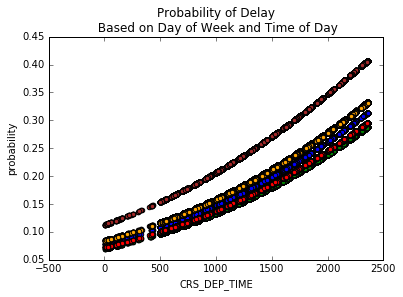

In [24]:
# Visualise probability of delay by day of week and time of day
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME',
                                  y='probability',
                                  kind='scatter',
                                  color=c,
                                  ax=ax)

ax.set(title='Probability of Delay\n Based on Day of Week and Time of Day')

## Activity: "Try It Out"
1. Adjust the model to make delay predictions using airlines instead of day of week, and time, then plot the effect on DEP_DEL15=1.
2. Try plotting the inverse: pick either model and plot the effect on DEP_DEL15=0.

#### 1. Visualise P(delay) vs airline

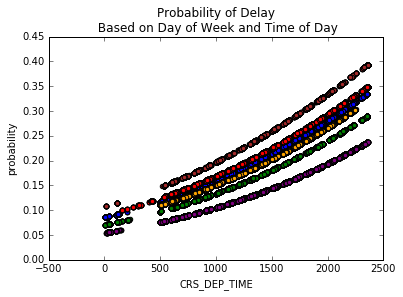

In [26]:
features = [i for i in df.columns if 'carrier_' in i] + ['CRS_DEP_TIME']
model.fit(df[features], df['DEP_DEL15'])
df['probability'] = model.predict_proba(df[features]).T[1]

ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME',
                                  y='probability',
                                  kind='scatter',
                                  color=c,
                                  ax=ax)

ax.set(title='Probability of Delay\n Based on Day of Week and Time of Day')

#### 2. Visualise the inverse (i.e. plot effect on DEP_DEL15=0)

In [33]:
df['probability_DEP_DEL15_0'] = model.predict_proba(df[features]).T[0]

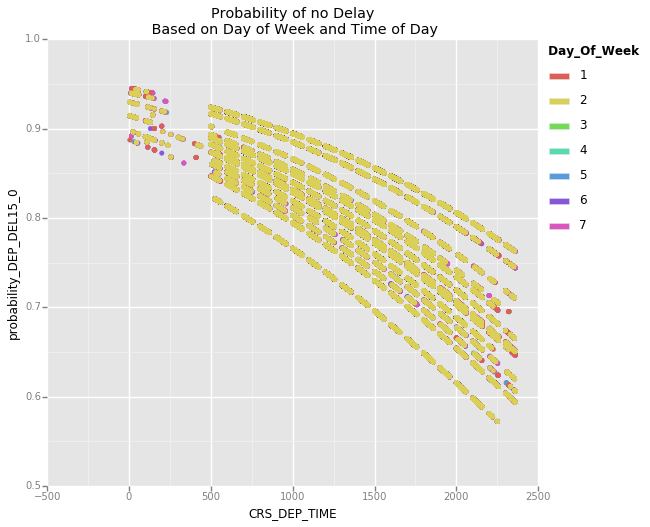

<ggplot: (301995977)>

In [32]:

# Using ggplot this time

from ggplot import ggplot, aes, geom_point, ggtitle

ggplot(df, aes('CRS_DEP_TIME', 'probability_DEP_DEL15_0', colour = 'DAY_OF_WEEK')) + \
    geom_point() + \
    ggtitle('Probability of no Delay\n Based on Day of Week and Time of Day')

## Demo: "Visualising Performance Against Baseline"

#### Visualising AUC and comparing models

In [ ]:
from sklearn import dummy, metrics

In [ ]:
features = [i for i in df.columns if 'dow_' in i][1:] + ['CRS_DEP_TIME']
features

In [ ]:
# Fit dummy model
dummy_model = dummy.DummyClassifier()
dummy_model.fit(df[features], df['DEP_DEL15'])
df['probability_dummy'] = dummy_model.predict_proba(df[features]).T[1]

# Fit log-reg model
lr_model = lm.LogisticRegression()
lr_model.fit(df[features], df['DEP_DEL15'])
df['probability_logreg'] = lr_model.predict_proba(df[features]).T[1]

In [ ]:
# Visualise AUC for each
ax = plt.subplot(111)
vals = metrics.roc_curve(df['DEP_DEL15'], df['probability_dummy'])
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(df['DEP_DEL15'], df['probability_logreg'])
ax.plot(vals[0], vals[1])

ax.set(title='Area Under Curve for prediction delayed=1', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

## Activity: "Try It Out"
1. In a similar approach, use the sklearn precision_recall_curve function to enable you to plot the precision-recall curve of the four models from above.  Keep in mind precision in the first array is returned from the function, but the plot shows it as the y-axis.

2. Explain what is occurring when the recall is below 0.2.

3. Based on this performance, is there a clear winner at different thresholds?

4. **Bonus:**  Redo both the AUC and precision-recall curves using models that have been cross validated using k-fold. How do these new figures change your expectations for performance?

#### Visualising precision & recall

In [ ]:
# ...